# Auxiliary Classifier GANs



In [1]:
import torch
import torch.nn.functional as nn
import torch.autograd as autograd
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from torch.autograd import Variable
%matplotlib inline

mb_size = 32
z_dim = 16
X_dim = 784
y_dim = 10
h_dim = 128
cnt = 0
lr = 1e-3
eps = 1e-8

setcuda = True


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


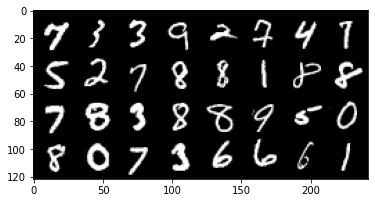

In [2]:
import torchvision.transforms as transforms
import torchvision

# load the dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0,), (1,))])
trainset = torchvision.datasets.MNIST(root='./data/', train=True,
                                        download=True,transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=mb_size,
                                          shuffle=True, num_workers=2)
classes = ('0','1','2','3','4','5','6','7','8','9')

def onehotencoder(x):
    y = np.zeros((x.numpy().shape[0],10))
    for i in range(x.numpy().shape[0]):
        y[i,x[i]] = 1
    return y

dataiter = iter(trainloader)
images, labels = dataiter.next()
import pdb
def mnist_next(dataiter):

    try:
        images, labels = dataiter.next()
        labels = onehotencoder(labels)
        images = images.view(images.numpy().shape[0],28*28)
    except:
        dataiter = iter(trainloader)
        images, labels = dataiter.next()
        labels = onehotencoder(labels)
        images = images.view(images.numpy().shape[0],28*28)
    return images.numpy(), labels

def initialize_loader(trainset):
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=mb_size,
                                          shuffle=True, num_workers=2)
    dataiter = iter(trainloader)
    return dataiter

images, labels = mnist_next(dataiter)
# print some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
img = torchvision.utils.make_grid(images)
npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()

In [3]:
G_ = torch.nn.Sequential(
    torch.nn.Linear(z_dim + y_dim, h_dim),
    torch.nn.PReLU(),
    torch.nn.Linear(h_dim, X_dim),
    torch.nn.Sigmoid()
)


def G(z, c):
    inputs = torch.cat([z, c], 1)
    return G_(inputs)

if setcuda:
    G_.cuda()

In [4]:
D_shared = torch.nn.Sequential(
    torch.nn.Linear(X_dim, h_dim),
    torch.nn.PReLU()
)

D_gan = torch.nn.Sequential(
    torch.nn.Linear(h_dim, 1),
    torch.nn.Sigmoid()
)

D_aux = torch.nn.Sequential(
    torch.nn.Linear(h_dim, y_dim),
    torch.nn.Softmax()
)


def D(X):
    h = D_shared(X)
    return D_gan(h), D_aux(h)

if setcuda:
    D_shared = D_shared.cuda()
    D_gan = D_gan.cuda()
    D_aux = D_aux.cuda()

In [5]:
nets = [G_, D_shared, D_gan, D_aux]

G_params = G_.parameters()
D_params = (list(D_shared.parameters()) + list(D_gan.parameters()) +
            list(D_aux.parameters()))


def reset_grad():
    for net in nets:
        net.zero_grad()


G_solver = optim.Adam(G_params, lr=lr)
D_solver = optim.Adam(D_params, lr=lr)

In [6]:
dataiter = initialize_loader(trainset)

for it in range(15000):
    # Sample data
#     pdb.set_trace()
    X, y = mnist_next(dataiter)
    
#     if X.shape[0]!=mb_size:
#         continue
        
    if setcuda:
        X = Variable(torch.from_numpy(X).cuda())
        c = Variable(torch.from_numpy(y.astype('float32')).cuda())
        y_true = Variable(torch.from_numpy(y.argmax(axis=1).astype('int')).cuda())
        z = Variable(torch.randn(mb_size, z_dim).cuda())
    else:
        X = Variable(torch.from_numpy(X))
        # c is one-hot
        c = Variable(torch.from_numpy(y.astype('float32')))
        # y_true is not one-hot (requirement from nn.cross_entropy)
        y_true = Variable(torch.from_numpy(y.argmax(axis=1).astype('int')))
        # z noise
        z = Variable(torch.randn(mb_size, z_dim))

    """ Discriminator """
    G_sample = G(z, c)
    D_real, C_real = D(X)
    D_fake, C_fake = D(G_sample)

    # GAN's D loss
    D_loss = torch.mean(torch.log(D_real + eps) + torch.log(1 - D_fake + eps))
    # Cross entropy aux loss
    C_loss = -nn.cross_entropy(C_real, y_true) - nn.cross_entropy(C_fake, y_true)

    # Maximize
    DC_loss = -(D_loss + C_loss)

    DC_loss.backward()
    D_solver.step()

    reset_grad()

    """ Generator """
    G_sample = G(z, c)
    D_fake, C_fake = D(G_sample)
    _, C_real = D(X)

    # GAN's G loss
    G_loss = torch.mean(torch.log(D_fake + eps))
    # Cross entropy aux loss
    C_loss = -nn.cross_entropy(C_real, y_true) - nn.cross_entropy(C_fake, y_true)

    # Maximize
    GC_loss = -(G_loss + C_loss)

    GC_loss.backward()
    G_solver.step()

    reset_grad()

    # Print and plot every now and then
    if it % 15000 == 0:
        idx = np.random.randint(0, 10)
        c = np.zeros([16, y_dim])
        c[range(16), idx] = 1
        c = Variable(torch.from_numpy(c.astype('float32')))


        print('Iter-{}; D_loss: {:.4}; G_loss: {:.4}; Idx: {}'
              .format(it, -D_loss.item(), -G_loss.item(), idx))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Iter-0; D_loss: 1.391; G_loss: 1.267; Idx: 1
Iter-1000; D_loss: 0.1679; G_loss: 5.549; Idx: 7
Iter-2000; D_loss: 0.2913; G_loss: 3.989; Idx: 7
Iter-3000; D_loss: 0.3471; G_loss: 3.15; Idx: 7
Iter-4000; D_loss: 0.4538; G_loss: 3.169; Idx: 4
Iter-5000; D_loss: 0.39; G_loss: 3.154; Idx: 6
Iter-6000; D_loss: 0.3242; G_loss: 2.63; Idx: 4
Iter-7000; D_loss: 0.5278; G_loss: 2.625; Idx: 0
Iter-8000; D_loss: 0.8468; G_loss: 1.642; Idx: 4
Iter-9000; D_loss: 0.6536; G_loss: 2.564; Idx: 8


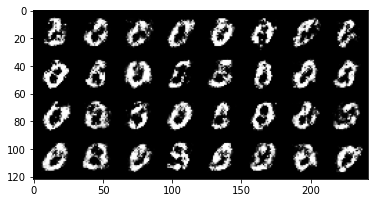

In [7]:
import torchvision

if setcuda:
    z = Variable(torch.randn(mb_size, z_dim).cuda())
    discr_codes = Variable(torch.zeros(mb_size,10).cuda())
else:
    z = Variable(torch.randn(mb_size, z_dim))
    discr_codes = Variable(torch.zeros(mb_size, 10))
discr_codes[:,0] = 1 
samples = G(z,discr_codes)
samples = samples.cpu()
img = samples.data
img = img.view([mb_size,1,28,28])
img = torchvision.utils.make_grid(img)
img = img.permute(1,2,0)
plt.imshow(img.numpy())